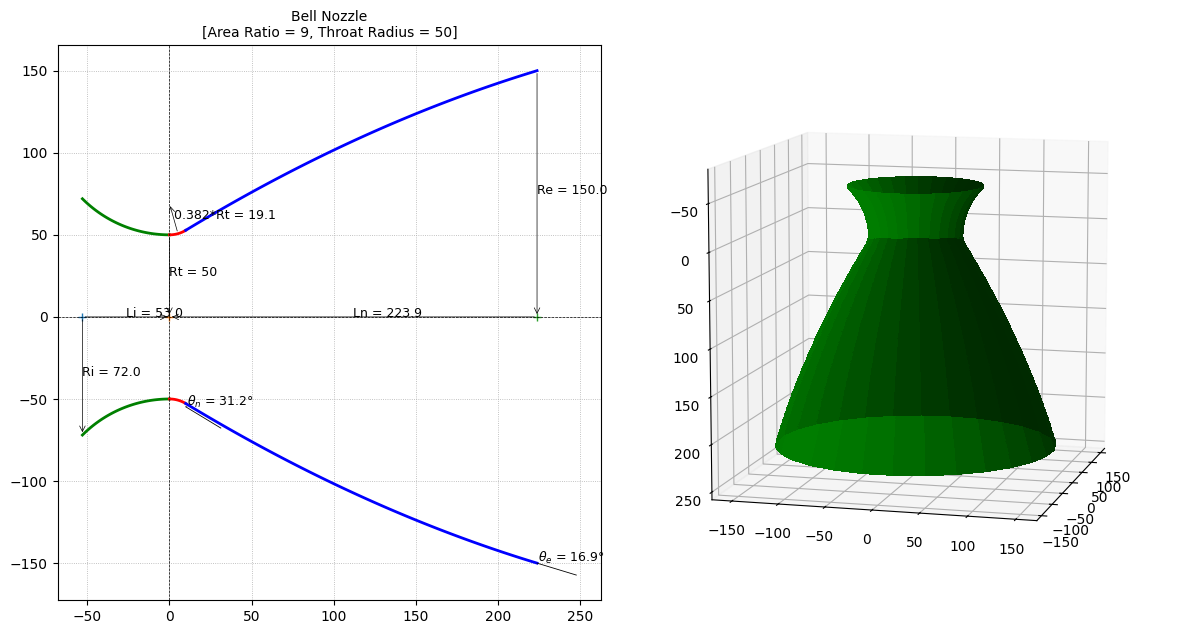

Saved: C:\Users\Owner\Downloads\bell_nozzle_wall_contour.txt


In [6]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from bisect import bisect_left

"""
Bell (Rao-style) nozzle generator and plotter
- Uses empirical θ_n / θ_e tables with interpolation
- Builds entrant arc, exit arc, and quadratic Bézier bell
- Plots 2D + simple 3D surface of revolution
- Exports positive-wall contour to NX-friendly TXT
"""

# ---------------------------- Core geometry ---------------------------- #

def bell_nozzle(k, aratio, Rt, l_percent):
    """Return (angles, contour) for a bell nozzle.
       angles = (Ln, theta_n [rad], theta_e [rad])
       contour = (xe, ye, -ye, xe2, ye2, -ye2, xbell, ybell, -ybell)
    """
    # entrant arc: θ from -135° to -90°
    entrant_angle = -135.0
    ea_start = math.radians(entrant_angle)
    ea_end   = -math.pi / 2
    data_n = 100
    angle_list = np.linspace(ea_start, ea_end, data_n)
    xe  = 1.5 * Rt * np.cos(angle_list)
    ye  = 1.5 * Rt * np.sin(angle_list) + 2.5 * Rt

    # nozzle wall angles and nominal length
    Ln, theta_n, theta_e = find_wall_angles(aratio, Rt, l_percent)

    # exit arc: θ from -90° to (θ_n - 90°)
    angle_list = np.linspace(-math.pi/2, theta_n - math.pi/2, data_n)
    xe2 = 0.382 * Rt * np.cos(angle_list)
    ye2 = 0.382 * Rt * np.sin(angle_list) + 1.382 * Rt

    # Bézier bell endpoints
    Nx = 0.382 * Rt * math.cos(theta_n - math.pi/2)
    Ny = 0.382 * Rt * math.sin(theta_n - math.pi/2) + 1.382 * Rt

    # Ex from length %, Ey from area ratio
    Lnp = {60:0.6, 80:0.8, 90:0.9}.get(int(l_percent), 0.8)
    Ex = Lnp * ((math.sqrt(aratio) - 1.0) * Rt) / math.tan(math.radians(15.0))
    Ey = math.sqrt(aratio) * Rt

    # Tangent intersection for Bézier control point Q
    m1 = math.tan(theta_n)
    m2 = math.tan(theta_e)
    C1 = Ny - m1 * Nx
    C2 = Ey - m2 * Ex
    Qx = (C2 - C1) / (m1 - m2)
    Qy = (m1 * C2 - m2 * C1) / (m1 - m2)

    # Quadratic Bézier curve
    t = np.linspace(0.0, 1.0, data_n)
    xbell = (1 - t)**2 * Nx + 2*(1 - t)*t * Qx + t**2 * Ex
    ybell = (1 - t)**2 * Ny + 2*(1 - t)*t * Qy + t**2 * Ey

    return (Ln, theta_n, theta_e), (
        xe,  ye,  -ye,
        xe2, ye2, -ye2,
        xbell, ybell, -ybell
    )


def find_wall_angles(ar, Rt, l_percent=80):
    """Interpolate θ_n and θ_e (deg) from tables; return (Ln, θn_rad, θe_rad)."""
    ar_tab = np.array([4, 5, 10, 20, 30, 40, 50, 100], dtype=float)
    thn_60 = np.array([26.5, 28.0, 32.0, 35.0, 36.2, 37.1, 35.0, 40.0])
    thn_80 = np.array([21.5, 23.0, 26.3, 28.8, 30.0, 31.0, 31.5, 33.5])
    thn_90 = np.array([20.0, 21.0, 24.0, 27.0, 28.5, 29.5, 30.2, 32.0])
    the_60 = np.array([20.5, 20.5, 16.0, 14.5, 14.0, 13.5, 13.0, 11.2])
    the_80 = np.array([14.0, 13.0, 11.0,  9.0,  8.5,  8.0,  7.5,  7.0])
    the_90 = np.array([11.5, 10.5,  8.0,  7.0,  6.5,  6.0,  6.0,  6.0])

    if   int(l_percent) == 60: thn, the, Lnp = thn_60, the_60, 0.6
    elif int(l_percent) == 90: thn, the, Lnp = thn_90, the_90, 0.9
    else:                      thn, the, Lnp = thn_80, the_80, 0.8

    # geometric length factor
    f1 = ((math.sqrt(ar) - 1.0) * Rt) / math.tan(math.radians(15.0))
    Ln = Lnp * f1

    # interpolate angles in degrees
    thn_deg = float(np.interp(ar, ar_tab, thn))
    the_deg = float(np.interp(ar, ar_tab, the))
    return Ln, math.radians(thn_deg), math.radians(the_deg)


# ----------------------------- Plotting -------------------------------- #

def plot_nozzle(ax, title, Rt, angles, contour):
    Ln, theta_n, theta_e = angles
    xe, ye, nye, xe2, ye2, nye2, xbell, ybell, nybell = contour

    ax.set_aspect('equal')

    # entrant (green)
    ax.plot(xe,  ye,  'g', linewidth=2.0)
    ax.plot(xe,  nye, 'g', linewidth=2.0)

    # inlet radius & length dims
    ax.plot(xe[0], 0, '+')
    ax.annotate("", xy=(xe[0], 0), xytext=(xe[0], nye[0]),
                arrowprops=dict(lw=0.5, arrowstyle='<-'))
    ax.text(xe[0], 0.5*nye[0], f"Ri = {abs(nye[0]):.1f}", fontsize=9)

    ax.plot(0, 0, '+')
    ax.annotate("", xy=(xe[0], 0), xytext=(0, 0),
                arrowprops=dict(lw=0.5, arrowstyle='<-'))
    ax.text(0.5*xe[0], 0, f"Li = {abs(xe[0]):.1f}", fontsize=9)

    # throat radius
    ax.annotate("", xy=(xe[-1], ye[-1]), xytext=(0, 0),
                arrowprops=dict(lw=0.5, arrowstyle='<-'))
    ax.text(0.5*xe[-1], 0.5*ye[-1], f"Rt = {Rt:g}", fontsize=9)

    # exit (red)
    ax.plot(xe2,  ye2,  'r', linewidth=2.0)
    ax.plot(xe2,  nye2, 'r', linewidth=2.0)

    # display entrant/exit arc dimensions
    ax.annotate("", xy=(xe2[len(xe2)//2], ye2[len(ye2)//2]),
                xytext=(0, 1.382*Rt), arrowprops=dict(lw=0.5, arrowstyle='<-'))
    ax.text(0.5*xe2[len(xe2)//2], 0.5*(1.382*Rt+ye2[len(ye2)//2]),
            f"0.382*Rt = {0.382*Rt:.1f}", fontsize=9)

    # bell (blue)
    ax.plot(xbell,  ybell,  'b', linewidth=2.0)
    ax.plot(xbell,  nybell, 'b', linewidth=2.0)

    # exit radius (Re) from bell end y
    Re = float(ybell[-1])
    ax.plot(xbell[-1], 0, '+')
    ax.annotate("", xy=(xbell[-1], ybell[-1]), xytext=(xbell[-1], 0),
                arrowprops=dict(lw=0.5, arrowstyle='<-'))
    ax.text(xbell[-1], 0.5*ybell[-1], f"Re = {Re:.1f}", fontsize=9)

    # nozzle length
    ax.annotate("", xy=(xbell[-1], 0), xytext=(0, 0),
                arrowprops=dict(lw=0.5, arrowstyle='<-'))
    ax.text(0.5*xbell[-1], 0, f"Ln = {Ln:.1f}", fontsize=9)

    # angles
    draw_angle_arc(ax, theta_n, [xe2[-1], nye2[-1]-2.0], r'$\theta_n$')
    draw_angle_arc(ax, theta_e, [xbell[-1], nybell[-1]], r'$\theta_e$')

    ax.axhline(0, color='k', lw=0.5, ls='--')
    ax.axvline(0, color='k', lw=0.5, ls='--')
    ax.grid(True, which='both', linestyle=':', linewidth=0.6)
    ax.set_title(title, fontsize=10)


def draw_angle_arc(ax, theta_rad, origin, label=r'$\theta$'):
    startx, starty = origin
    length = 50.0
    endx = startx + math.cos(-theta_rad) * length * 0.5
    endy = starty + math.sin(-theta_rad) * length * 0.5
    ax.plot([startx, endx], [starty, endy], color='k', lw=0.6)
    deg = math.degrees(theta_rad)
    arc = Arc((startx, starty), 1, 1, angle=0, theta1=0, theta2=deg, color='k')
    ax.add_patch(arc)
    ax.text(startx + 0.6, starty + 0.6, f"{label} = {deg:.1f}°", fontsize=9)


# -------------------------- Simple 3D surface --------------------------- #

def ring(r, h, a=0, n_theta=30, n_height=10):
    theta = np.linspace(0, 2*np.pi, n_theta)
    v = np.linspace(a, a+h, n_height)
    theta, v = np.meshgrid(theta, v)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = v
    return x, y, z

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])

def set_axes_equal_3d(ax):
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def plot3D(ax, contour):
    xe, ye, _, xe2, ye2, _, xbell, ybell, _ = contour
    x = np.r_[xe, xe2, xbell]
    y = np.r_[ye, ye2, ybell]
    thick = abs(5.0 * (x[1] - x[0])) if len(x) > 1 else 1.0
    for xi, ri in zip(x, y):
        X, Y, Z = ring(ri, thick, xi)
        ax.plot_surface(X, Y, Z, color='g', linewidth=0, antialiased=False)
    ax.set_box_aspect([1, 1, 1])
    set_axes_equal_3d(ax)
    ax.view_init(elev=-170, azim=-15)


def plot(title, Rt, angles, contour):
    fig = plt.figure(figsize=(12, 9))
    ax1 = fig.add_subplot(121)
    plot_nozzle(ax1, title, Rt, angles, contour)
    ax2 = fig.add_subplot(122, projection='3d')
    plot3D(ax2, contour)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# ------------------------------- Main ---------------------------------- #

if __name__ == "__main__":
    # constants
    k = 1.21        # ratio of specific heats (not used in geometry here)
    l_percent = 60  # 60, 80, or 90

    # ---- ONLY ONE NOZZLE: Area Ratio = 9 ----
    aratio = 9
    throat_radius = 50  # mm

    angles, contour = bell_nozzle(k, aratio, throat_radius, l_percent)
    title = f"Bell Nozzle\n[Area Ratio = {aratio}, Throat Radius = {throat_radius}]"
    plot(title, throat_radius, angles, contour)

    # ---------- Export NX-friendly TXT for positive wall ----------
    x_wall = list(contour[0]) + list(contour[3]) + list(contour[6])  # xe + xe2 + xbell
    y_wall = list(contour[1]) + list(contour[4]) + list(contour[7])  # ye + ye2 + ybell

    downloads_folder = os.path.join(os.path.expanduser("~"), "Downloads")
    os.makedirs(downloads_folder, exist_ok=True)
    txt_path = os.path.join(downloads_folder, "bell_nozzle_wall_contour.txt")

    min_distance = 0.01  # mm spacing filter
    with open(txt_path, "w") as f:
        last_x = last_y = None
        for x, y in zip(x_wall, y_wall):
            if last_x is None or math.hypot(x - last_x, y - last_y) >= min_distance:
                f.write(f"{x:.6f} {y:.6f} 0.000000\n")
                last_x, last_y = x, y

    print(f"Saved: {txt_path}")
